# Feed Forward Neural Network
Pada percobaan kali ini kita akan menggunakan dataset MNIST yaitu dataset yang berisi gambar-gambar angka tulisan tangan.

**Import Library yang Digunakan**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

**Menggunakan GPU apabila memungkinkan**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Hyperparameter**
- input sebesar 794 didapat dari ukuran piksel pada satu buah gambar
- output sebesar 10 didapat dari jumlah kelas yang ada, yaitu angka digit dari 0 - 9

In [3]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

### Mempersiapkan Dataset
**Train Test**
Torchvision menyediakan beberapa datasets yang kerap digunakan pada library ```torchvision.datasets```. Informasi lebih lanjut dapat dilihat pada [dokumentasi ```torchvision.datasets```](https://pytorch.org/vision/stable/datasets.html). Khusus untuk dataset MNIST, detail lebih lengkap dapat dilihat pada [tautan berikut ini](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).
- ```root='./data'```: Lokasi dataset yang akan digunakan.
- ```train=True```: Menentukan dataset yang digunakan untuk training atau tidak.
- ```transform=transforms.ToTensor()```: Transformasi yang akan dilakukan pada dataset.
- ```download=True```: Download dataset jika belum ada.

**DataLoader**
Detail tentang DataLoader dapat dilihat pada [dokumentasi berikut ini](https://pytorch.org/docs/stable/data.html).
- ```dataset```: Dataset yang akan digunakan.
- ```batch_size```: Banyaknya data yang akan dibatasi dalam satu batch.
- ```shuffle```: Untuk membuat data diacak atau tidak.

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

Ukuran sample: torch.Size([100, 1, 28, 28])
Ukuran label: torch.Size([100])


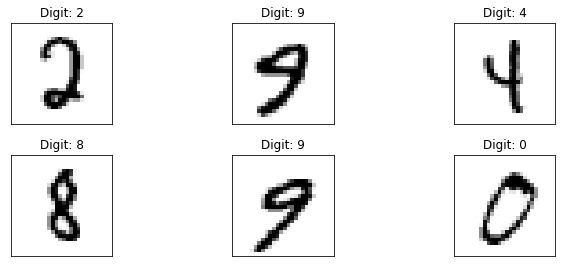

In [5]:
example_batch = iter(train_loader)
samples, labels = example_batch.next()
print(f'Ukuran sample: {samples.shape}')
print(f'Ukuran label: {labels.shape}')

# show 6 samples image with label using subplot
fig = plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(samples[i][0], cmap='gist_yarg')
    plt.title("Digit: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

**Penjelasan Contoh Data**
Terdapat 100 sampel data pada contoh batch yang dicetak dimana setiap gambar berukuran 28x28 pixel dan ditransformasi menjadi tensor dengan dimensi (1, 28, 28).

### Definisi Model

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

**Loss dan Optimizer**
- Kita akan menggunakan ```CrossEntropyLoss``` untuk menghitung loss.
- Pada loss function itu sudah terdapat ```Softmax``` yang akan menghasilkan probabilitas untuk setiap kelas.
- Untuk optimizer, kita akan menggunakan ```Adam``` optimizer.
- ```optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)```

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training Loop**
- images perlu di reshape karena input yang kita gunakan pada neural network berukuran 784
- sebelumnya images memiliki dimensi (1, 28, 28) -> 1 channel, 28 pixel panjang, 28 pixel lebar
- Diubah menjadi array dengan dimensi (1, 784)

In [17]:
n_total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_step}], Loss: {loss.item():.4f}')




Epoch [1/2], Step [100/600], Loss: 0.0019
Epoch [1/2], Step [200/600], Loss: 0.0027
Epoch [1/2], Step [300/600], Loss: 0.0079
Epoch [1/2], Step [400/600], Loss: 0.0018
Epoch [1/2], Step [500/600], Loss: 0.0051
Epoch [1/2], Step [600/600], Loss: 0.0260
Epoch [2/2], Step [100/600], Loss: 0.0004
Epoch [2/2], Step [200/600], Loss: 0.0023
Epoch [2/2], Step [300/600], Loss: 0.0004
Epoch [2/2], Step [400/600], Loss: 0.0089
Epoch [2/2], Step [500/600], Loss: 0.0021
Epoch [2/2], Step [600/600], Loss: 0.0059


### Testing the Model

In [9]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    accuracy = 100.0 * n_correct / n_samples
    print(f'Akurasi: {accuracy}')

Akurasi: 97.07
